In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import vstack
import json
import math

In [2]:
train_df = pd.read_json(path_or_buf="./data/train.jsonl", lines=True)
test_df = pd.read_json(path_or_buf="./data/test.jsonl", lines=True)
val_df = pd.read_json(path_or_buf="./data/validation.jsonl", lines=True)
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [3]:
train_df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


Text(0, 0.5, 'Count')

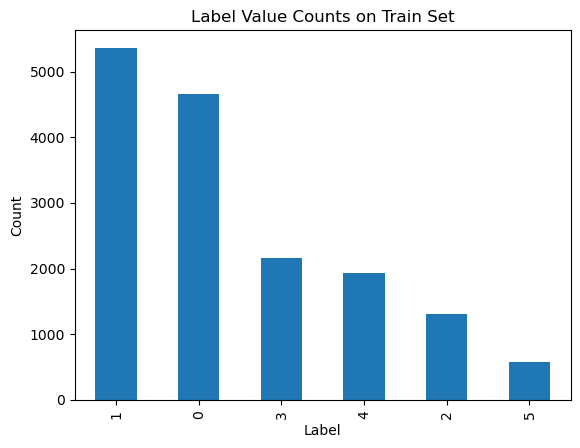

In [4]:
ax = train_df["label"].value_counts().plot(kind='bar', title='Label Value Counts on Train Set')
ax.set_xlabel("Label")
ax.set_ylabel("Count")

In [5]:
train_x = train_df['text'].to_numpy()
train_y = train_df['label'].to_numpy()

# sadness = train_df[train_df['label'] == 0 ].to_numpy()
# joy = train_df[train_df['label'] == 1 ].to_numpy()
# love = train_df[train_df['label'] == 2 ].to_numpy()
# anger = train_df[train_df['label'] == 3 ].to_numpy()
# fear = train_df[train_df['label'] == 4 ].to_numpy()
# surprise = train_df[train_df['label'] == 4 ].to_numpy()

value_counts = train_df['label'].value_counts().sort_index().to_numpy()

print("shape of train inputs: ", train_x.shape)
print("shape of train outputs: ", train_y.shape)
print()
print("label value counts:\n",value_counts)
print()

label_prior_probs = []
for i in range(5):
    prior = value_counts[i] / train_x.shape[0]
    label_prior_probs.append(prior)

print("label empirical prior probabilities:\n",label_prior_probs)

shape of train inputs:  (16000,)
shape of train outputs:  (16000,)

label value counts:
 [4666 5362 1304 2159 1937  572]

label empirical prior probabilities:
 [0.291625, 0.335125, 0.0815, 0.1349375, 0.1210625]


## Extracting Features from Text:
Bag of words model:
- Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).
- For each tweet #i, count the number of occurrences of each word w and store it in X[i, j] as the value of feature #j where j is the index of word w in the dictionary.

Tokenizing text with scikit-learn:
- Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_x)
X_train_counts.shape

(16000, 15186)

In [7]:
#dict vocabluary: words and counts
#vectorizer has built a dictionary of feature indices
#The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.
from operator import itemgetter
vocab = count_vect.vocabulary_
vocab.get(u'happy')

5988

## From Occurences to Frequencies 

from: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


"Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using TfidfTransformer:"

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(16000, 15186)

# Implement Naive Bayes

In [35]:
class naive_bayes():
    def __init__(self, data, alpha=0.25):
        self.X = data['text'].to_numpy()
        self.Y = data['label'].to_numpy()
        self.alpha = alpha
        self.vocab ={}
        self.data = data
        self.inputs = self.sparse_matrix(data)
        self.n_features = self.inputs.shape[1]
        self.n_inputs = self.inputs.shape[0]
        self.n_labels = 6 
        self.grouped_classes = self.separate_classes()
        self.wordFrequencies=self.get_w_freqs() 
        self.totalWordFrequencies=self.get_total_w_freqs() 
        self.priors = None
        self.posteriors = None

    def print_stuff(self):
        print("n features:", self.n_features)
        print("n inputs:", self.n_inputs)
        print("priors:", self.priors)
        print("total word freqs:\n", self.totalWordFrequencies)


    def sparse_matrix(self, D, test=False):
        sentences = D['text'].to_numpy()
        vectorizer = CountVectorizer(vocabulary=self.vocab) if test else CountVectorizer()
        X_counts = vectorizer.fit_transform(sentences)
        
        if not test:
            self.vocab = vectorizer.vocabulary_
        
        return X_counts  # Returns a sparse matrix
    
    def separate_classes(self):
        grouped_classes = []
        for i in range(self.n_labels):
            class_data = self.data[self.data['label'] == i]
            class_sparse_matrix = self.sparse_matrix(class_data, test=True)  # Convert to sparse matrix
            grouped_classes.append(class_sparse_matrix)

        return grouped_classes
        
    def get_priors(self):
        value_counts = self.data['label'].value_counts().sort_index().to_numpy()
        label_prior_probs = []
        for i in range(self.n_labels):
            prior = value_counts[i] / self.data.shape[0]
            label_prior_probs.append(prior)
        return label_prior_probs
    
    def get_w_freqs(self):
        res = [None] * self.n_labels
        for c in range(self.n_labels):
            # Stack all sentence vectors for class c
            sentences = vstack(self.grouped_classes[c])
            # Sum along the columns (axis=0) to get total frequencies per feature for class c
            res[c] = np.array(sentences.sum(axis=0)).ravel()  # Convert to 1D array
        return res

    def get_total_w_freqs(self):
        res = [0] * self.n_labels
        for c in range(self.n_labels):
            # Stack all sentence vectors for class c
            sentences = vstack(self.grouped_classes[c])
            # Sum all elements to get total word frequency for class c
            res[c] = sentences.sum()
        return res

    # def get_post_probs(self):
    #     post_probs = np.zeros((self.n_labels, self.n_features))

    #     for c in range(self.n_labels):
    #         # Ensure word frequencies have the correct shape
    #         if self.wordFrequencies[c].shape[0] != self.n_features:
    #             raise ValueError(f"Shape mismatch in word frequencies for class {c}: "
    #                             f"expected {self.n_features}, got {self.wordFrequencies[c].shape[0]}")

    #         # Handle zero total word frequencies by adding a small constant
    #         total_freq = self.totalWordFrequencies[c] if self.totalWordFrequencies[c] > 0 else 1e-10
    #         post_probs[c] = np.divide(self.wordFrequencies[c], total_freq)

    #     return post_probs

    def get_post_probs(self):
        # self.alpha = 1  # Laplace smoothing factor
        post_probs = np.zeros((self.n_labels, self.n_features))

        for c in range(self.n_labels):
            # Apply Laplace smoothing
            word_freqs_with_smoothing = self.wordFrequencies[c] + self.alpha
            total_freq = self.totalWordFrequencies[c] + self.alpha * self.n_features
            post_probs[c] = np.divide(word_freqs_with_smoothing, total_freq)

        return post_probs
        
    def predict_on_sentence(self, sentence):
        log_probabilities = np.zeros(self.n_labels)

        for i in range(self.n_labels):
            # Ensure self.priors[i] is a scalar
            if np.isscalar(self.priors[i]):
                log_p = np.log(self.priors[i])
            else:
                raise ValueError("Prior probability is not a scalar")

            for j in range(self.n_features):
                # Check if self.posteriors[i][j] is a scalar
                if np.isscalar(self.posteriors[i][j]):
                    # Handle zero probabilities
                    posterior = self.posteriors[i][j] if self.posteriors[i][j] > 0 else 1e-10
                    log_p += sentence[j] * np.log(posterior)
                else:
                    raise ValueError("Posterior probability is not a scalar")

            log_probabilities[i] = log_p

        # Converting log probabilities back to normal scale
        max_log = np.max(log_probabilities)
        probabilities = np.exp(log_probabilities - max_log)
        pSum = np.sum(probabilities)
        probabilities = probabilities / pSum

        return probabilities

    
    def predict_on_df(self, test_x):
        yh = []
        x = self.sparse_matrix(test_x, test= True)
        
        for sentence in x:
            # Convert each sparse row to a dense array
            dense_sentence = sentence.toarray().ravel()
            ys = self.predict_on_sentence(dense_sentence)
            yh.append(np.argmax(ys))

        return yh
        
    def fit(self):
        priors=self.get_priors()
        self.priors=priors
        
        posteriors=self.get_post_probs()
        self.posteriors=posteriors
        
    def evaluate_acc(self, test_x):
        y_true = test_x['label'].to_numpy()  # Actual labels
        y_pred = self.predict_on_df(test_x)        # Predicted labels
        accuracy = np.mean(y_true == y_pred)
        return accuracy

In [36]:
model=naive_bayes(train_df) 
model.fit()
model.print_stuff()

print("Test accuracy:", model.evaluate_acc(test_df))
print("Validation accuracy:", model.evaluate_acc(val_df))

n features: 15186
n inputs: 16000
priors: [0.291625, 0.335125, 0.0815, 0.1349375, 0.1210625, 0.03575]
total word freqs:
 [75827, 93243, 24115, 36829, 32360, 10157]
Test accuracy: 0.8015
Validation accuracy: 0.8055


## Results
- Alpha = 0 (no smoothing):
    - Test accuracy: 0.7115
    - Validation accuracy: 0.697 
- Alpha = 1:
    - Test accuracy: 0.7655
    - Validation accuracy: 0.7615
- Alpha = 0.5:
    - Test accuracy: 0.8
    - Validation accuracy: 0.8045
- Alpha = 0.25:
    - Test accuracy: 0.8015
    - Validation accuracy: 0.8055
### Ideas for Exploration
- Tuning alpha
- use of tf–idf weights instead of raw term frequencies 
- stop-word removal
- n-grams